In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [3]:
IMAGE_SIZE = 256
EPOCHS = 10
CHANNELS = 3
BATCH_SIZE = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 234 files belonging to 2 classes.


In [5]:
class_name = dataset.class_names

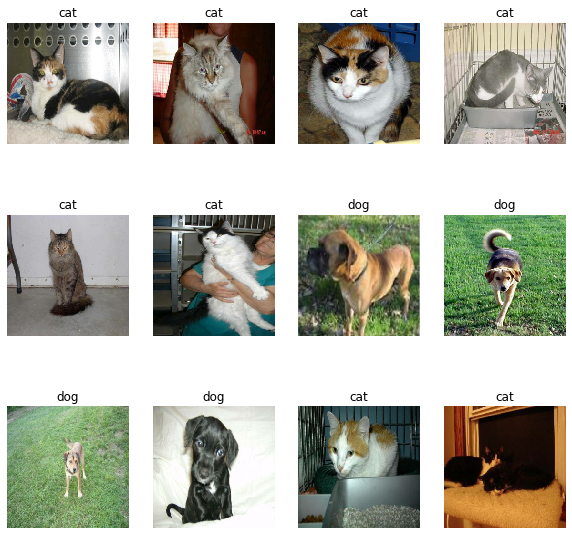

In [6]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for index in range(12):        
        ax = plt.subplot(3,4,index+1)
        plt.imshow(image[index].numpy().astype("uint8"))
        plt.title(class_name[label[index].numpy()])
        plt.axis("off")

In [7]:
def train_test_split(ds,test = 0.1,val = 0.1 , train = 0.8,shuffle=True):
    ds_size = len(ds)
    train_size = int(train*ds_size)
    test_size = int(test*ds_size)

    if shuffle:
        ds.shuffle(1000,seed = 12)
    
    train_data = ds.take(train_size)
    test_data = ds.skip(train_size).take(test_size)
    val_data = ds.skip(train_size).skip(test_size)
    
    return train_data,test_data,val_data

In [8]:
train_ds , test_ds ,val_ds = train_test_split(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [10]:
from tensorflow.keras import layers

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(2,activation="softmax"),
])

In [13]:
mod = model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
6/6 [==============================] - 46s 8s/step - loss: 17.7108 - accuracy: 0.4948 - val_loss: 3.6619 - val_accuracy: 0.4762
Epoch 2/10
6/6 [==============================] - 19s 3s/step - loss: 1.3839 - accuracy: 0.5052 - val_loss: 0.8827 - val_accuracy: 0.4286
Epoch 3/10
6/6 [==============================] - 22s 4s/step - loss: 0.8370 - accuracy: 0.4740 - val_loss: 0.7026 - val_accuracy: 0.5714
Epoch 4/10
6/6 [==============================] - 11s 2s/step - loss: 0.7362 - accuracy: 0.4531 - val_loss: 0.6849 - val_accuracy: 0.4524
Epoch 5/10
6/6 [==============================] - 12s 2s/step - loss: 0.7141 - accuracy: 0.4688 - val_loss: 0.6809 - val_accuracy: 0.5476
Epoch 6/10
6/6 [==============================] - 14s 2s/step - loss: 0.6947 - accuracy: 0.5312 - val_loss: 0.6884 - val_accuracy: 0.5476
Epoch 7/10
6/6 [==============================] - 13s 2s/step - loss: 0.6756 - accuracy: 0.5469 - val_loss: 0.6627 - val_accuracy: 0.5952
Epoch 8/10
6/6 [=================

In [23]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    

    print("First image to predict")
    plt.imshow(first_image)
    print("actual lable ",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    

In [25]:
# import pickle as pk
# pk.dumps(history,open("modeldc.h5","wb"))

In [17]:
model.save('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [18]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [19]:
img = plt.imread("cat9.jpg")

In [22]:
# model.predict(img)

In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)